In [13]:
import os
import gc
import sys
from PIL import Image
import cv2
import math, random
import numpy as np
import pandas as pd
from glob import glob
from tqdm import tqdm
import matplotlib.pyplot as plt
import pydicom
import re

In [14]:
# import zipfile
# file_name = "rsna-2024-lumbar-spine-degenerative-classification.zip"
# output_dir = "input/rsna2024-lsdc-making-dataset"
# zip_file = zipfile.ZipFile(file_name)
# zip_file.extractall(path=output_dir)

In [8]:
rd = './input/rsna2024-lsdc-making-dataset'

In [4]:
dfc = pd.read_csv(f'{rd}/train_label_coordinates.csv')

In [5]:
df = pd.read_csv(f'{rd}/train_series_descriptions.csv')
df.head()

,study_id,series_id,series_description
0,4003253,702807833,Sagittal T2/STIR
1,4003253,1054713880,Sagittal T1
2,4003253,2448190387,Axial T2
3,4646740,3201256954,Axial T2
4,4646740,3486248476,Sagittal T1


In [6]:
df['series_description'].value_counts()

series_description
Axial T2            2340
Sagittal T1         1980
Sagittal T2/STIR    1974
Name: count, dtype: int64

In [8]:
df.info(), dfc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6294 entries, 0 to 6293
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   study_id            6294 non-null   int64 
 1   series_id           6294 non-null   int64 
 2   series_description  6294 non-null   object
dtypes: int64(2), object(1)
memory usage: 147.6+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48692 entries, 0 to 48691
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   study_id         48692 non-null  int64  
 1   series_id        48692 non-null  int64  
 2   instance_number  48692 non-null  int64  
 3   condition        48692 non-null  object 
 4   level            48692 non-null  object 
 5   x                48692 non-null  float64
 6   y                48692 non-null  float64
dtypes: float64(2), int64(3), object(2)
memory usage: 2.6+ MB


(None, None)

In [31]:
## (Left/Right) Neural Foraminal Narrowing → Sagittal T1
## (Left/Right) Subarticular Stenosis → Axial T2
## Spinal Canal Stenosis → Sagittal T2/STIR
df_merge = pd.merge(left = dfc , right = df[['series_id','series_description']], how = "inner", on = "series_id")
df_merge[['condition','series_description']].value_counts()

condition                         series_description
Left Neural Foraminal Narrowing   Sagittal T1           9860
Right Neural Foraminal Narrowing  Sagittal T1           9859
Spinal Canal Stenosis             Sagittal T2/STIR      9748
Right Subarticular Stenosis       Axial T2              9612
Left Subarticular Stenosis        Axial T2              9608
Spinal Canal Stenosis             Sagittal T1              5
Name: count, dtype: int64

In [23]:
def imread_and_imwirte(src_path, dst_path):
    dicom_data = pydicom.dcmread(src_path)
    image = dicom_data.pixel_array
    image = (image - image.min()) / (image.max() - image.min() +1e-6) * 255
    img = cv2.resize(image, (512, 512),interpolation=cv2.INTER_CUBIC)
    assert img.shape==(512,512)
    cv2.imwrite(dst_path, img)

In [25]:
## study_id 중복값 X
st_ids = df['study_id'].unique()

In [30]:
## description 종류
desc = df['series_description'].unique().tolist()
desc

['Sagittal T2/STIR', 'Sagittal T1', 'Axial T2']

In [32]:
## 문자열 text가 정수라면, string → int
def atoi(text):
    return int(text) if text.isdigit() else text

## 문자열 내 정수 공백으로 구분
def natural_keys(text):
    return [ atoi(c) for c in re.split(r'(\d+)', text) ]

In [38]:
for idx, si in enumerate(tqdm(st_ids, total=len(st_ids))):
    pdf = df[df['study_id']==si]
    for ds in desc:
        ds_ = ds.replace('/', '_')
        pdf_ = pdf[pdf['series_description']==ds]
        os.makedirs(f'cvt_png/{si}/{ds_}', exist_ok=True)
        allimgs = []
        for i, row in pdf_.iterrows():
            pimgs = glob(f'{rd}/train_images/{row["study_id"]}/{row["series_id"]}/*.dcm')
            pimgs = sorted(pimgs, key=natural_keys)
            allimgs.extend(pimgs)
            
        if len(allimgs)==0:
            print(si, ds, 'has no images')
            continue

        if ds == 'Axial T2':
            for j, impath in enumerate(allimgs):
                dst = f'cvt_png/{si}/{ds}/{j:03d}.png'
                imread_and_imwirte(impath, dst)
                
        elif ds == 'Sagittal T2/STIR':
            
            step = len(allimgs) / 10.0
            st = len(allimgs)/2.0 - 4.0*step
            end = len(allimgs)+0.0001
            for j, i in enumerate(np.arange(st, end, step)):
                dst = f'cvt_png/{si}/{ds_}/{j:03d}.png'
                ind2 = max(0, int((i-0.5001).round()))
                imread_and_imwirte(allimgs[ind2], dst)
                
            assert len(glob(f'cvt_png/{si}/{ds_}/*.png'))==10
                
        elif ds == 'Sagittal T1':
            step = len(allimgs) / 10.0
            st = len(allimgs)/2.0 - 4.0*step
            end = len(allimgs)+0.0001
            for j, i in enumerate(np.arange(st, end, step)):
                dst = f'cvt_png/{si}/{ds}/{j:03d}.png'
                ind2 = max(0, int((i-0.5001).round()))
                imread_and_imwirte(allimgs[ind2], dst)
                
            assert len(glob(f'cvt_png/{si}/{ds}/*.png'))==10

 57%|█████▋    | 1126/1975 [28:02<17:52,  1.26s/it] 

2492114990 Sagittal T1 has no images


 64%|██████▍   | 1272/1975 [31:28<14:46,  1.26s/it]

2780132468 Sagittal T1 has no images


 70%|██████▉   | 1378/1975 [34:13<12:11,  1.22s/it]

3008676218 Sagittal T2/STIR has no images


100%|██████████| 1975/1975 [50:06<00:00,  1.52s/it]


---------------------

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import tensorflow as tf
import tensorflow.keras.layers as tfl

from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation

In [8]:
rd = './input/rsna2024-lsdc-making-dataset'

In [9]:
df = pd.read_csv(f'{rd}/train.csv')
df.head()

,study_id,spinal_canal_stenosis_l1_l2,spinal_canal_stenosis_l2_l3,spinal_canal_stenosis_l3_l4,spinal_canal_stenosis_l4_l5,spinal_canal_stenosis_l5_s1,left_neural_foraminal_narrowing_l1_l2,left_neural_foraminal_narrowing_l2_l3,left_neural_foraminal_narrowing_l3_l4,left_neural_foraminal_narrowing_l4_l5,...,left_subarticular_stenosis_l1_l2,left_subarticular_stenosis_l2_l3,left_subarticular_stenosis_l3_l4,left_subarticular_stenosis_l4_l5,left_subarticular_stenosis_l5_s1,right_subarticular_stenosis_l1_l2,right_subarticular_stenosis_l2_l3,right_subarticular_stenosis_l3_l4,right_subarticular_stenosis_l4_l5,right_subarticular_stenosis_l5_s1
0,4003253,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,...,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild
1,4646740,Normal/Mild,Normal/Mild,Moderate,Severe,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,...,Normal/Mild,Normal/Mild,Normal/Mild,Severe,Normal/Mild,Normal/Mild,Moderate,Moderate,Moderate,Normal/Mild
2,7143189,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,...,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild
3,8785691,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,...,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild
4,10728036,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,...,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,Normal/Mild


In [10]:
# Replace : Nans → -100 
df = df.fillna(-100)

In [11]:
# Labeling : Normal/Mild = 0, Moderate = 1, Severe = 2
LabelToId = {'Normal/Mild':0, 'Moderate':1, 'Severe':2}
df = df.replace(LabelToId)
df.head()

C:\Users\pc\AppData\Local\Temp\ipykernel_11604\3244378648.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(LabelToId)


,study_id,spinal_canal_stenosis_l1_l2,spinal_canal_stenosis_l2_l3,spinal_canal_stenosis_l3_l4,spinal_canal_stenosis_l4_l5,spinal_canal_stenosis_l5_s1,left_neural_foraminal_narrowing_l1_l2,left_neural_foraminal_narrowing_l2_l3,left_neural_foraminal_narrowing_l3_l4,left_neural_foraminal_narrowing_l4_l5,...,left_subarticular_stenosis_l1_l2,left_subarticular_stenosis_l2_l3,left_subarticular_stenosis_l3_l4,left_subarticular_stenosis_l4_l5,left_subarticular_stenosis_l5_s1,right_subarticular_stenosis_l1_l2,right_subarticular_stenosis_l2_l3,right_subarticular_stenosis_l3_l4,right_subarticular_stenosis_l4_l5,right_subarticular_stenosis_l5_s1
0,4003253,0,0,0,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0
1,4646740,0,0,1,2,0,0,0,0,1,...,0,0,0,2,0,0,1,1,1,0
2,7143189,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,8785691,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,10728036,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


Found 119449 files belonging to 1975 classes.
['100206310', '1002894806', '1004726367', '1008446160', '1009445512', '1009905322', '1012375618', '1013589491', '1013791258', '1018005303', '1019430579', '1020394063', '1025265129', '1028684462', '1028909382', '1035170868', '1036203708', '1038453736', '1039182563', '1040921274', '1047914296', '1050200728', '1051198661', '1051595826', '1051657831', '1057173941', '105895264', '106310815', '10728036', '1075351916', '1075863395', '107698245', '1078357909', '107935613', '1079625817', '1082591956', '1082665764', '108348787', '1084486898', '1085426528', '1086363712', '1087298370', '1088270559', '1093392148', '109454808', '1094670148', '1094879459', '1095894979', '1096630192', '109677683', '1097875334', '1099112122', '110271740', '1103373889', '1104422628', '1105006429', '1106510276', '1115481506', '1115952008', '1116588610', '111701877', '1117361192', '1117492266', '1119763924', '1121141304', '112166434', '1123923932', '1125605580', '1125872530', 

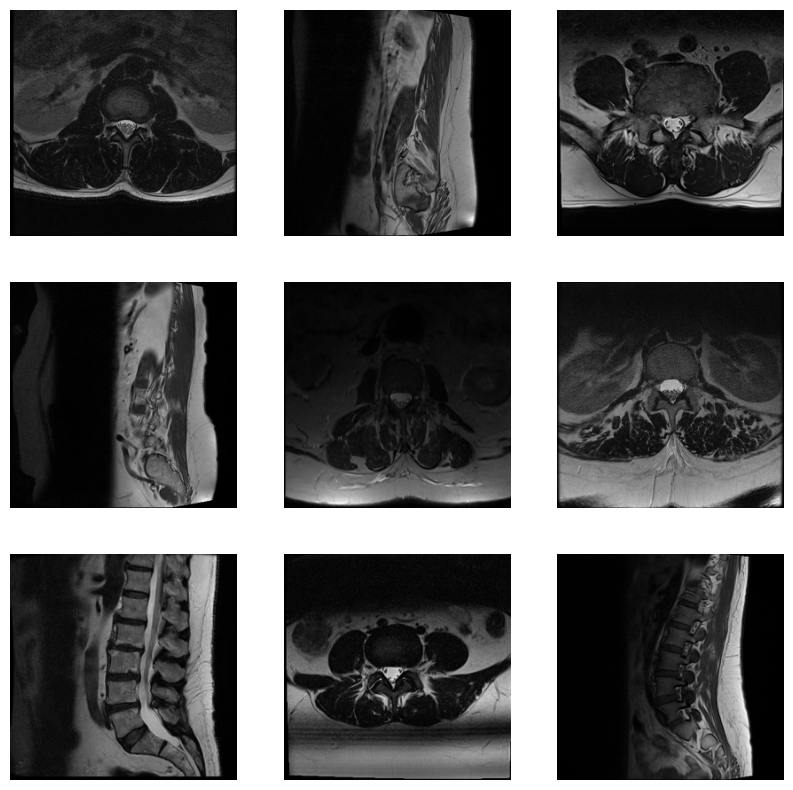

In [19]:
directory = "cvt_png"
train_ds = image_dataset_from_directory(
    directory,
    labels='inferred',
    label_mode='categorical',
    batch_size=32,
    image_size=(256, 256))

# 라벨들 이름 출력        
class_names = train_ds.class_names
print(class_names)

# 이미지 9개 샘플 출력
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.axis("off")